In [1]:
import logging

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import talib
from binance.enums import HistoricalKlinesType
from matplotlib import pyplot as plt
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from main_funcs import get_and_update_data

In [2]:
# configs
country=None
joft = "BTCUSDT"
interval = "1d"

# remove small candle 
zero_remover_pct = 0.0

# add history of open_close_pct 
open_close_pct_history_count = 100

# add history of max_low_high_pct 
max_low_high_pct_history_count = -1

# calculate rsi with different lengths 
rsi_ranges = range(14, 14)

# add history of rsi
rsi_history_count = -1

# add moving average of rsi
rsi_ma_lengths = [3,7,9,10,14,20,50,100]
rsi_ma_ranges = []


In [3]:
# validation config

# valid rsi_ma_ranges
for r in  rsi_ma_ranges:
    if not r in rsi_ranges:
        raise ValueError("rsi_ma_ranges items is not in rsi_ranges")

In [4]:
# get data from database
df_source = get_and_update_data(joft, interval, HistoricalKlinesType.SPOT, country=country)
df_source = df_source[["open", "high", "low", "close", "volume"]]
# df_source.tail(1)

In [5]:
# calculate parameters
df_cal = df_source.copy()

# change from open to other columns
df_cal['open_close'] = df_cal.close - df_cal.open
df_cal['open_low'] = df_cal.low - df_cal.open
df_cal['open_high'] = df_cal.high - df_cal.open

# change percent from open to other columns
df_cal['open_close_pct'] = df_cal.open_close / df_cal.open
df_cal['open_low_pct'] = df_cal.open_low / df_cal.open
df_cal['open_high_pct'] = df_cal.open_high / df_cal.open

# price direction
# df_target['open_close_direction'] = np.sign(df_target["open_close"])
# df_target['open_open_high_direction'] = np.sign(df_target["open_low"]).astype(int)
# df_target['open_high_direction'] = np.sign(df_target["open_high"]).astype(int)

# max abs low and high
df_cal['max_low_high_pct'] = np.where(
    df_cal['open_low_pct'].abs() > df_cal['open_high_pct'].abs(),
    df_cal['open_low_pct'],
    df_cal['open_high_pct']
)

# open_close_pct history
for h in range(0,open_close_pct_history_count+1):
    df_cal[f"open_close_pct__{h}"] = df_cal.open_close_pct.shift(h)
    

# max_low_high_pct history
for h in range(0,max_low_high_pct_history_count+1):
    df_cal[f"max_low_high_pct__{h}"] = df_cal.max_low_high_pct.shift(h)
    

# calculate multi rsi
for rsi in rsi_ranges:
    for h in range(0, rsi_history_count + 1):
        df_cal[f"rsi_{rsi}__{h}"] = talib.RSI(df_cal.close.shift(h), timeperiod=rsi)
        
# calculate rsi sma 
for ma_length in rsi_ma_lengths:
    for rsi in rsi_ma_ranges:
        df_cal[f"rsi_{rsi}_ma_{ma_length}"] =  talib.SMA(df_cal[f"rsi_{rsi}__{0}"], timeperiod=ma_length)
# df_cal

C:\Users\sajja\AppData\Local\Temp\ipykernel_53064\3199498739.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cal[f"open_close_pct__{h}"] = df_cal.open_close_pct.shift(h)
C:\Users\sajja\AppData\Local\Temp\ipykernel_53064\3199498739.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cal[f"open_close_pct__{h}"] = df_cal.open_close_pct.shift(h)
C:\Users\sajja\AppData\Local\Temp\ipykernel_53064\3199498739.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [6]:
# create calculate target
df_target = df_cal.copy()
mabna = 'open_close_pct'

# calculate target
# df_target["target"] = df_target[mabna]
df_target["target"] = np.where(
    df_target[mabna] > zero_remover_pct,
    df_target[mabna],
    np.where(
        df_target[mabna] < -zero_remover_pct,
        df_target[mabna], 0
    )
)

# add log
# df_target["target"] = np.log(df_target["target"])

# shift target the real place
df_target["target"] = df_target["target"].shift(-1)
# df_target

In [7]:
# clean data
df = df_target.copy()
df.dropna(inplace=True)
df.drop(columns=['open', 'high', 'low', 'close', 'volume', 'open_close', 'open_low', 'open_high',
                 'open_close_pct', 'open_low_pct', 'open_high_pct', 'max_low_high_pct'], inplace=True)


df

,open_close_pct__0,open_close_pct__1,open_close_pct__2,open_close_pct__3,open_close_pct__4,open_close_pct__5,open_close_pct__6,open_close_pct__7,open_close_pct__8,open_close_pct__9,...,open_close_pct__92,open_close_pct__93,open_close_pct__94,open_close_pct__95,open_close_pct__96,open_close_pct__97,open_close_pct__98,open_close_pct__99,open_close_pct__100,target
open_time,,,,,,,,,,,,,,,,,,,,,
2017-11-25 03:30:00,0.068930,0.014717,-0.025876,0.014192,-0.011322,0.019224,0.035566,0.010668,-0.022571,0.086236,...,-0.008186,0.040755,0.018319,0.005976,-0.013057,-0.008418,0.007694,-0.041238,0.005538,0.049193
2017-11-26 03:30:00,0.049193,0.068930,0.014717,-0.025876,0.014192,-0.011322,0.019224,0.035566,0.010668,-0.022571,...,0.013252,-0.008186,0.040755,0.018319,0.005976,-0.013057,-0.008418,0.007694,-0.041238,0.057187
2017-11-27 03:30:00,0.057187,0.049193,0.068930,0.014717,-0.025876,0.014192,-0.011322,0.019224,0.035566,0.010668,...,-0.005193,0.013252,-0.008186,0.040755,0.018319,0.005976,-0.013057,-0.008418,0.007694,0.025575
2017-11-28 03:30:00,0.025575,0.057187,0.049193,0.068930,0.014717,-0.025876,0.014192,-0.011322,0.019224,0.035566,...,0.017791,-0.005193,0.013252,-0.008186,0.040755,0.018319,0.005976,-0.013057,-0.008418,-0.021109
2017-11-29 03:30:00,-0.021109,0.025575,0.057187,0.049193,0.068930,0.014717,-0.025876,0.014192,-0.011322,0.019224,...,0.053709,0.017791,-0.005193,0.013252,-0.008186,0.040755,0.018319,0.005976,-0.013057,0.015595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-10 03:30:00,0.016363,0.030214,0.006373,0.010073,0.000977,-0.001431,0.009946,-0.006434,-0.013547,0.022565,...,-0.004267,-0.006329,0.019149,0.004216,0.000560,-0.001438,-0.002729,0.000262,-0.017504,-0.004601
2023-11-11 03:30:00,-0.004601,0.016363,0.030214,0.006373,0.010073,0.000977,-0.001431,0.009946,-0.006434,-0.013547,...,-0.001009,-0.004267,-0.006329,0.019149,0.004216,0.000560,-0.001438,-0.002729,0.000262,-0.001774
2023-11-12 03:30:00,-0.001774,-0.004601,0.016363,0.030214,0.006373,0.010073,0.000977,-0.001431,0.009946,-0.006434,...,0.000141,-0.001009,-0.004267,-0.006329,0.019149,0.004216,0.000560,-0.001438,-0.002729,-0.016221


C:\Users\sajja\AppData\Local\Temp\ipykernel_53064\2996477991.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['target'],bins=100)


<Axes: xlabel='target', ylabel='Density'>

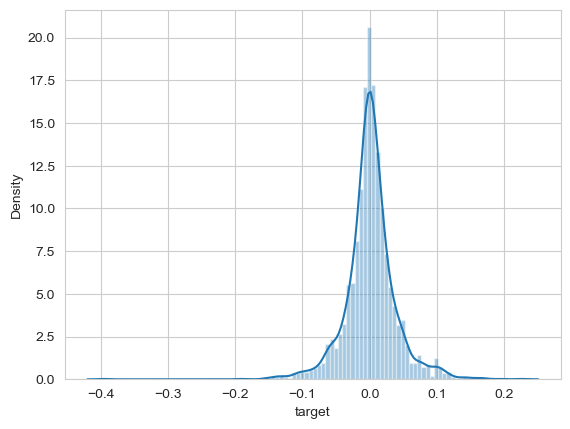

In [8]:
sns.distplot(df['target'],bins=100)

In [9]:
# analyse df
print("shape df: ", df.shape)
df.corr()['target'].sort_values(ascending=False)

shape df:  (2181, 102)


target                1.000000
open_close_pct__32    0.053842
open_close_pct__64    0.051250
open_close_pct__74    0.048918
open_close_pct__9     0.046963
                        ...   
open_close_pct__92   -0.037198
open_close_pct__45   -0.039197
open_close_pct__97   -0.040772
open_close_pct__31   -0.043849
open_close_pct__0    -0.047160
Name: target, Length: 102, dtype: float64

In [10]:
# # convert all columns to scaler format betwen 0 1
# scaler = preprocessing.MinMaxScaler()
# arr_scaled = scaler.fit_transform(df)
# df_edited = pd.DataFrame(arr_scaled, columns=df.columns,index=df.index)
# 
# # add logarithm to all columns
# # df_edited = df_edited.apply(lambda x: np.log(x))
# df_edited = df_edited.apply(lambda x: np.sqrt(x))
# 
# df = df_edited.copy()
# df


In [11]:
# create cross validator
# Data and targets
X, Y = df.iloc[:, :-1], df.iloc[:, -1]

In [21]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
model = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=6, eval_metric='MAE', verbose=10,task_type='GPU')
x_train, x_test, y_train, y_test = train_test_split(X, Y)
model.fit(x_train, y_train, eval_set=(x_test, y_test))

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.0253263	test: 0.0254774	best: 0.0254774 (0)	total: 21.6ms	remaining: 3m 36s
10:	learn: 0.0252233	test: 0.0254480	best: 0.0254480 (10)	total: 207ms	remaining: 3m 8s
20:	learn: 0.0251234	test: 0.0254444	best: 0.0254434 (15)	total: 376ms	remaining: 2m 58s
30:	learn: 0.0249913	test: 0.0254289	best: 0.0254289 (30)	total: 540ms	remaining: 2m 53s
40:	learn: 0.0248824	test: 0.0254196	best: 0.0254196 (40)	total: 698ms	remaining: 2m 49s
50:	learn: 0.0247747	test: 0.0254315	best: 0.0254192 (45)	total: 872ms	remaining: 2m 50s
60:	learn: 0.0246821	test: 0.0254373	best: 0.0254192 (45)	total: 1.03s	remaining: 2m 48s
70:	learn: 0.0245756	test: 0.0254396	best: 0.0254192 (45)	total: 1.2s	remaining: 2m 47s
80:	learn: 0.0244953	test: 0.0254461	best: 0.0254192 (45)	total: 1.35s	remaining: 2m 45s
90:	learn: 0.0243948	test: 0.0254509	best: 0.0254192 (45)	total: 1.51s	remaining: 2m 44s
100:	learn: 0.0243127	test: 0.0254240	best: 0.0254192 (45)	total: 1.67s	remaining: 2m 43s
110:	learn: 0.0242273	t

In [13]:
# print(f"{model.get_best_score()['validation']['MAE']} ** 2 = {model.get_best_score()['validation']['MAE']**2}")

In [14]:
# ????